___

<a href='http://www.pieriandata.com'> <img src='../Pierian_Data_Logo.png' /></a>
___
# Logistic Regression with Python

For this lecture we will be working with the [Titanic Data Set from Kaggle](https://www.kaggle.com/c/titanic). This is a very famous data set and very often is a student's first step in machine learning!

We'll be trying to predict a classification- survival or deceased.
Let's begin our understanding of implementing Logistic Regression in Python for classification.

We'll use a "semi-cleaned" version of the titanic data set, if you use the data set hosted directly on Kaggle, you may need to do some additional cleaning not shown in this lecture notebook.

## Import Libraries
Let's import some libraries to get started!

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## The Data

Let's start by reading in the titanic_train.csv file into a pandas dataframe.

Data Dictionary
Variable	Definition	Key
survival	Survival	0 = No, 1 = Yes

pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd

sex	Sex
Age	Age in years
sibsp	# of siblings / spouses aboard the Titanic
parch	# of parents / children aboard the Titanic
ticket	Ticket number
fare	Passenger fare
cabin	Cabin number
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

Variable Notes
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...

Sibling = brother, sister, stepbrother, stepsister

Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...

Parent = mother, father

Child = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch=0 for them.

In [71]:
train = pd.read_csv("C:\\Users\\staff\\Downloads\\titanic_train (1).csv")

In [72]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [73]:
train.shape

(891, 12)

# Exploratory Data Analysis

Let's begin some exploratory data analysis! We'll start by checking out missing data!

## Missing Data

We can use seaborn to create a simple heatmap to see where we are missing data!

In [74]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

<Axes: >

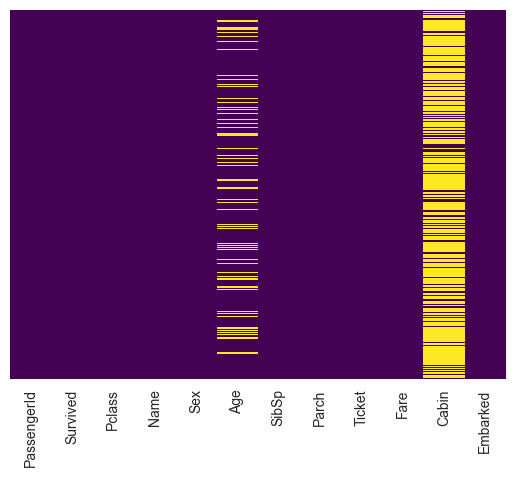

In [75]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of imputation. Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level. We'll probably drop this later, or change it to another feature like "Cabin Known: 1 or 0"

Let's continue on by visualizing some more of the data! Check out the video for full explanations over these plots, this code is just to serve as reference.

<Axes: xlabel='Survived', ylabel='count'>

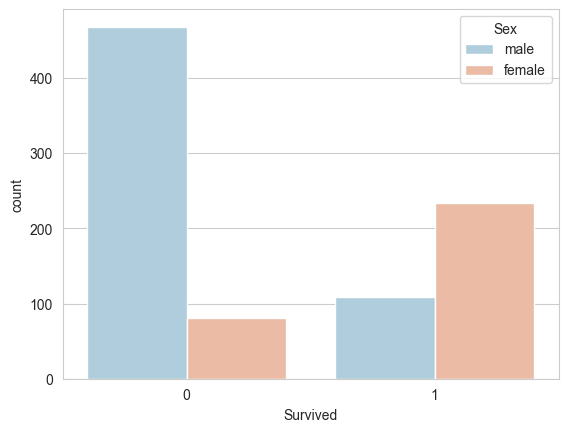

In [76]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')

<Axes: xlabel='Survived', ylabel='count'>

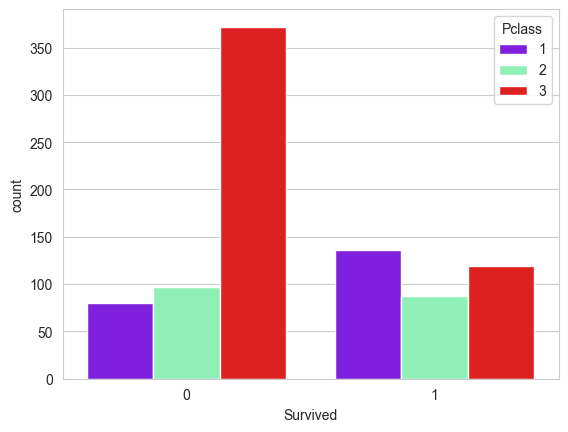

In [77]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=train,palette='rainbow')

<Axes: >

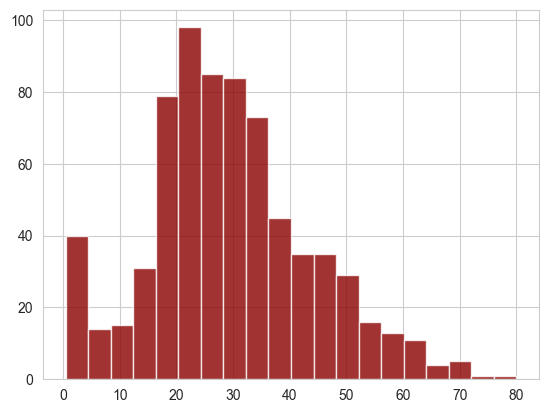

In [78]:
train['Age'].hist(bins=20,color='darkred',alpha=0.8)

<Axes: xlabel='SibSp', ylabel='count'>

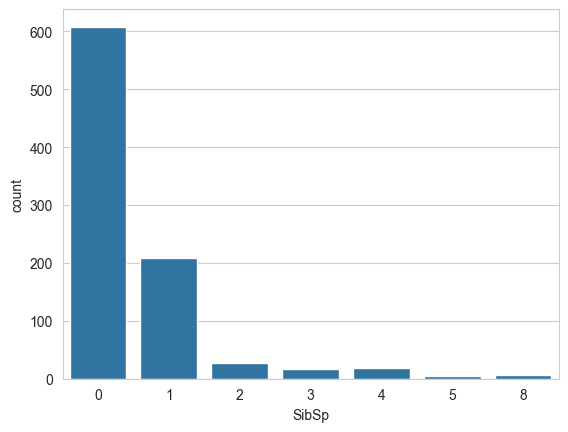

In [79]:
sns.countplot(x='SibSp',data=train)

<Axes: >

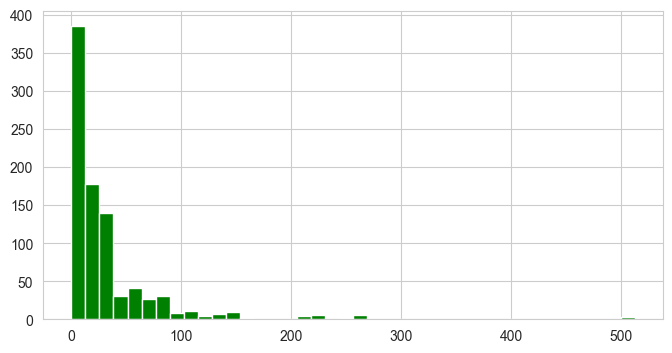

In [80]:
train['Fare'].hist(color='green',bins=40,figsize=(8,4))

___
## Data Cleaning
We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation).
However we can be smarter about this and check the average age by passenger class. For example:


We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age.

In [81]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]

    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

Now apply that function!

In [82]:
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)

C:\Users\staff\AppData\Local\Temp\ipykernel_15136\3438464256.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Age = cols[0]
C:\Users\staff\AppData\Local\Temp\ipykernel_15136\3438464256.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Pclass = cols[1]


Now let's check that heat map again!

<Axes: >

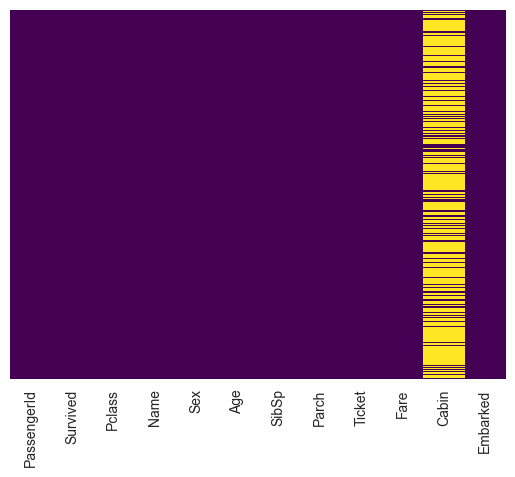

In [83]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Great! Let's go ahead and drop the Cabin column and the row in Embarked that is NaN.

In [84]:
train.drop('Cabin',axis=1,inplace=True)

In [85]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [86]:
train.dropna(inplace=True)

## Converting Categorical Features

We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [87]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [88]:
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)

In [89]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,24.0,1,2,W./C. 6607,23.4500,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C


In [90]:
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [91]:
train = pd.concat([train,sex,embark],axis=1)

In [92]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,True,False,True
1,2,1,1,38.0,1,0,71.2833,False,False,False
2,3,1,3,26.0,0,0,7.9250,False,False,True
3,4,1,1,35.0,1,0,53.1000,False,False,True
4,5,0,3,35.0,0,0,8.0500,True,False,True


Great! Our data is ready for our model!

# Building a Logistic Regression model

Let's start by splitting our data into a training set and test set (there is another test.csv file that you can play around with in case you want to use all this data for training).

## Train Test Split

In [93]:
from sklearn.model_selection import train_test_split

In [94]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1),
                                                    train['Survived'], test_size=0.30,
                                                    random_state=101)

## Training and Predicting

In [95]:
from sklearn.linear_model import LogisticRegression

| Parameter             | Description                                                                                                                                                                             |
| --------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **penalty**           | `'l2'` → The type of regularization applied to avoid overfitting. `'l2'` is Ridge regularization (squares of weights).                                                                  |
| **dual**              | `False` → Whether to use the dual formulation of the optimization problem. Usually `False` for most cases (set `True` only for `'liblinear'` solver and when `n_samples > n_features`). |
| **tol**               | `0.0001` → The tolerance for stopping criteria. The smaller the value, the more precise (but slower) the training.                                                                      |
| **C**                 | `1.0` → Inverse of regularization strength. Smaller values imply **stronger** regularization. (Think of it as λ = 1/C in Ridge regression).                                             |
| **fit_intercept**     | `True` → Adds an intercept (bias) term to the model.                                                                                                                                    |
| **intercept_scaling** | `1` → Used only when solver = `'liblinear'` and `fit_intercept=True`. Usually left as 1.                                                                                                |
| **class_weight**      | `None` → Assigns weights to classes. `None` means all classes are treated equally. You can set `balanced` to handle imbalanced datasets.                                                |
| **random_state**      | `None` → Controls randomness for reproducibility. Set an integer (e.g., `random_state=42`) for consistent results.                                                                      |
| **solver**            | `'lbfgs'` → Optimization algorithm used to find parameters. `'lbfgs'` works well for small/medium datasets and supports multiclass problems.                                            |
| **max_iter**          | `100` → Maximum number of iterations for the solver to converge. Increase if the model fails to converge.                                                                               |
| **multi_class**       | `'deprecated'` → Previously used to control multiclass handling (`'ovr'` or `'multinomial'`). Newer versions handle this automatically.                                                 |
| **verbose**           | `0` → Controls verbosity (0 = silent). Increasing this prints progress during fitting.                                                                                                  |
| **warm_start**        | `False` → If `True`, reuse previous model’s solution for faster fitting in iterative runs.                                                                                              |
| **n_jobs**            | `None` → Number of CPU cores used for parallel processing. `None` = 1 core. Use `-1` to use all cores.                                                                                  |
| **l1_ratio**          | `None` → Used only if `penalty='elasticnet'`. Defines the mix between L1 and L2 regularization (0 = pure L2, 1 = pure L1).                                                              |


In [102]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

c:\Users\staff\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [97]:
predictions = logmodel.predict(X_test)

Let's move on to evaluate our model!

## Evaluation

We can check precision,recall,f1-score using classification report!

In [98]:
from sklearn.metrics import classification_report

In [99]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.79      0.91      0.85       163
           1       0.81      0.62      0.71       104

    accuracy                           0.80       267
   macro avg       0.80      0.77      0.78       267
weighted avg       0.80      0.80      0.79       267



In [100]:
from sklearn.metrics import confusion_matrix

In [101]:
print(confusion_matrix(y_test,predictions))

[[148  15]
 [ 39  65]]


Not so bad! You might want to explore other feature engineering and the other titanic_text.csv file, some suggestions for feature engineering:

* Try grabbing the Title (Dr.,Mr.,Mrs,etc..) from the name as a feature
* Maybe the Cabin letter could be a feature
* Is there any info you can get from the ticket?

## Great Job!